# Машинное обучение – весна 2024

# Домашнее задание 3: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
p_k1 = 8/10
p_k2 = 2/10
print(f'Энтропия распределения H = {-(p_k1*np.log(p_k1)+p_k2*np.log(p_k2)):0.2f}')

Энтропия распределения H = 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
H_Rl=H_Rr=0 #в левом и правом листе все объекты имеют метки одного типа
print(f'Критерий информативности Q = {(p_k1*(1-p_k1)+p_k2*(1-p_k2)) + H_Rl + H_Rr:0.2f}')

Критерий информативности Q = 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
l = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
print(f'Ответ для вершины: {np.sum(l)/len(l)}')

Ответ для вершины: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    def g(a: np.ndarray) -> float:
        _, counts = np.unique(a, return_counts=True)
        var = counts/len(a)
        return np.sum(var*(1-var))
    
    def q(H_l: float, H_r: float, H: float, len_l: float, len_r: float) -> float:
        return H - len_l/len(targets)*H_l - len_r/len(targets)*H_r
    
    features = np.array(feature_vector)
    targets = np.array(target_vector)
    
    if feature_type == 'real':
        mask = np.argsort(features)
        sorted_features = np.sort(features)
        sorted_targets = targets[mask]
        
        unique_features = np.unique(sorted_features)
        thresholds = (unique_features[:-1] + unique_features[1:])/2
    
        if task == 'regression':
            H = np.var(sorted_targets)
            q_r = lambda x: q(np.var(sorted_targets[sorted_features < x]), np.var(sorted_targets[sorted_features > x]), H, len(sorted_targets[sorted_features < x]), len(sorted_targets[sorted_features > x]))
            ginis = np.array(list(map(q_r, thresholds)))
        else:
            H = g(sorted_targets)
            q_c =  lambda x: q(g(sorted_targets[sorted_features < x]), g(sorted_targets[sorted_features > x]), H, len(sorted_targets[sorted_features < x]), len(sorted_targets[sorted_features > x]))
            ginis = np.array(list(map(q_c, thresholds)))
        
    if feature_type == 'categorical':
        thresholds = np.unique(features)
        
        if task == 'regression':
            H = np.var(targets)
            q_r = lambda x: q(np.var(targets[features == x]), np.var(targets[features != x]), H, len(targets[sorted_features == x]), len(targets[features != x]))
            ginis = np.array(list(map(q_r, thresholds)))
        else:
            H = g(targets)
            q_c = lambda x: q(g(targets[features == x]), g(targets[features != x]), H, len(targets[features == x]), len(targets[features != x]))
            ginis = np.array(list(map(q_c, thresholds)))
            
    gini_best = np.max(ginis)
    threshold_best = thresholds[np.argmax(ginis)]
        
    return tuple([thresholds, ginis, threshold_best, gini_best])

Эту функцию можно протестировать на датасете `California`.

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

Text(0, 0.5, 'ginis')

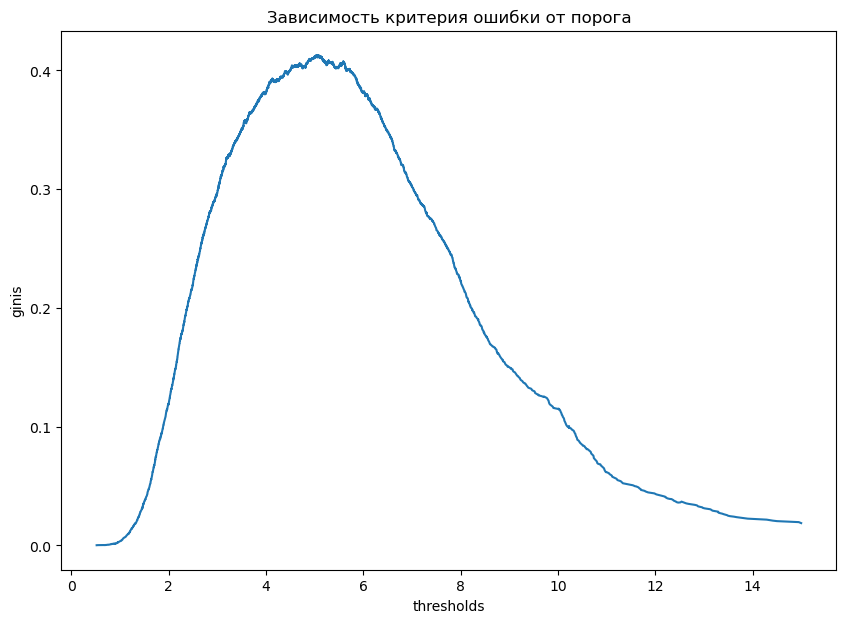

In [11]:
X_med = X['MedInc']

def gini_threshold(X, y, task, feature_type, label):
    answer = find_best_split(X, y, task, feature_type)
    plt.plot(answer[0], answer[1], label = label)

plt.figure(figsize=(10, 7))
plt.title("Зависимость критерия ошибки от порога")
gini_threshold(X_med, y, 'regression', 'real', None)
plt.xlabel("thresholds")
plt.ylabel("ginis")

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [12]:
best_splits = X.apply(find_best_split, axis = 0, args = [y, 'regression', 'real'])
best_splits = best_splits.rename(index = {0: 'tresholds', 1: 'ginis', 2: 'threshold_best', 3: 'gini_best'})
best_splits.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
tresholds,"[0.51795, 0.5427500000000001, 0.5964, 0.6604, ...","[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, ...","[0.8675213675213675, 0.9444444444444444, 1.065...","[0.35416666666666663, 0.4097222222222222, 0.47...","[4.0, 5.5, 7.0, 8.5, 10.0, 12.0, 13.5, 14.5, 1...","[0.7211538461538461, 0.8602941176470589, 1.015...","[32.545, 32.555, 32.565, 32.575, 32.585, 32.59...","[-124.32499999999999, -124.285, -124.265, -124..."
ginis,"[0.00010880339847685327, 0.0001855959365468784...","[7.585249523445192e-05, 4.6682038861600716e-05...","[9.532625096397851e-06, 4.661526639293534e-05,...","[2.249929594033695e-05, 3.0005573329328072e-05...","[9.927931175357507e-05, 0.00010815673438280271...","[7.432658259665104e-05, 9.013496220511286e-07,...","[9.40939178564193e-05, 0.0002071640493266358, ...","[6.105609976203574e-05, 0.00018296853368338084..."
threshold_best,5.03515,51.5,6.374305,1.103378,1160.5,3.112543,37.935,-121.865
gini_best,0.412751,0.030901,0.159208,0.015253,0.002831,0.073919,0.090334,0.050211


In [13]:
gini_best_of_all = best_splits.loc['gini_best'].max()
index = list(best_splits.loc['gini_best']).index(gini_best_of_all)
criteria_best_of_all = best_splits.columns[0]
threshold_best_of_all = best_splits[best_splits.columns[0]]['threshold_best']
print(f'Best criteria: {criteria_best_of_all} \nBest gini: {gini_best_of_all} \nBest threshold: {threshold_best_of_all}')

Best criteria: MedInc 
Best gini: 0.41275138620167656 
Best threshold: 5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [14]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:
        

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (sub_X[:, feature_best] < threshold_best)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (sub_X[:, feature_best] == threshold_best)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == 'terminal':
            return node["class"]
        else:
            if "threshold" in node.keys():
                if x[node["feature_split"]] < node["threshold"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
            else:
                if x[node["feature_split"]] == node["category_split"]:
                    return self._predict_node(x, node["left_child"])
                else: 
                    return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [15]:
data_1 = pd.read_csv('data/students.csv')
data_1.head(5)

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [16]:
X_1 = data_1.drop(['UNS', 'Unnamed: 0'], axis = 1)
y_1 = data_1['UNS']

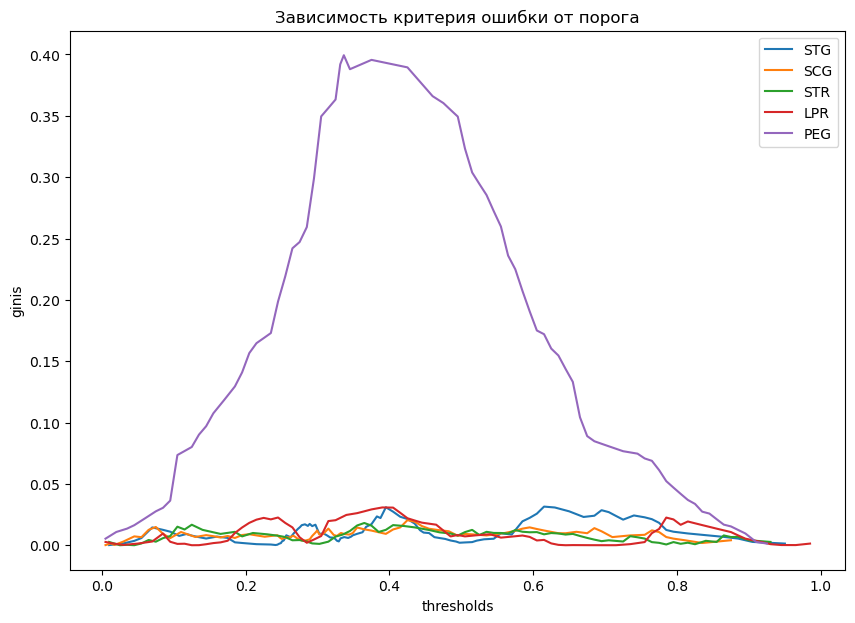

In [17]:
plt.figure(figsize=(10, 7))
plt.title("Зависимость критерия ошибки от порога")
for i in range(X_1.shape[1]):
    column = X_1.columns[i]
    gini_threshold(X_1[column], y_1, 'classification', 'real', column)
plt.xlabel("thresholds")
plt.ylabel("ginis")
plt.legend()

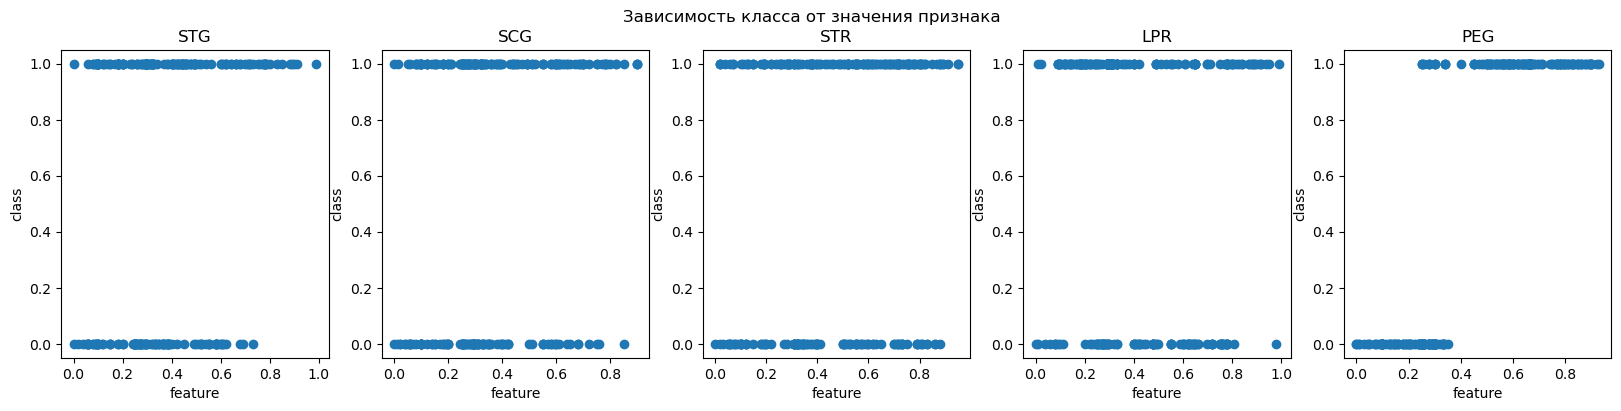

In [18]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Зависимость класса от значения признака")
for i in range(X_1.shape[1]):
    column = X_1.columns[i]
    ax[i].set_title(column)
    ax[i].scatter(X_1[column], y_1)
    ax[i].set_xlabel('feature')
    ax[i].set_ylabel('class')
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из значений критерия Джини на первом рисунке наиболее наибольшее значение критерия информативности Q достигается при делении выборки по признаку PEG. Кроме того только этот признак имеет единственный пик значений критерия Джини, то есть хаотичность достигает своего единственного минимума при выборе порога по признаку PEG соответствующего максимальному значению критерия Джини. Эти наблюдения согласуются с диаграммами рассеивания. PEG - признак по которому можно с большой точностью разделить объекты на два класса (провести вертикальную черту на диаграмме рассеяния так, что почти все объекты класса 0 останутся слева, класса 1 - справа). Таким образом, для "хороших" признаков зависимость критерия Джини и порога должна иметь единственный выраженный пик, диаграмма рассеивания должна хорошо линейно разделяться, как было только что описано. "Плохие" признаки будут иметь множество пиков хаотичности и классы будут принимать значения 0, 1 практически равновероятно независимо от значения порога (плохо разделяться).

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [19]:
data_2 = pd.read_csv("data/agaricus-lepiota.data", sep = ',', names = range(23))
for column in data_2.columns:
    data_2[column] = LabelEncoder().fit_transform(data_2[column])
data_2.head(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [20]:
X_2 = data_2.drop([0], axis = 1)
y_2 = data_2[0]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.5, random_state=13)

In [21]:
tree = DecisionTree(feature_types = np.repeat(['categorical'], 22))
tree.fit(X_train_2.to_numpy(), y_train_2.to_numpy())
y_pred = tree.predict(X_test_2.to_numpy())
print(f"Decision tree accuracy: {accuracy_score(y_test_2, y_pred)}")

Decision tree accuracy: 0.9992614475627769


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [22]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [23]:
data = pd.read_csv('data/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

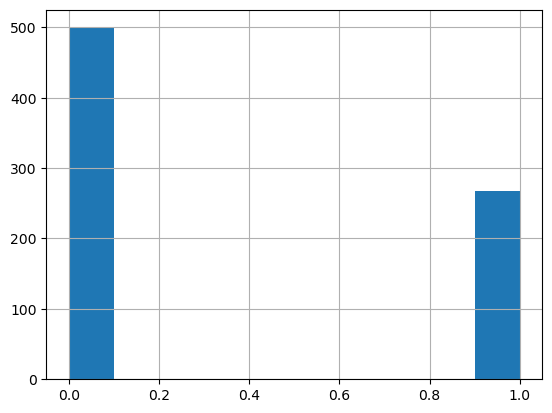

In [24]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [25]:
X = data.drop(['Outcome'], axis = 1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=13)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [26]:
max_depths = [None, 3, 5, 7]
min_samples_leafs = [15, 7, 5, 3, 1]
f1_scores = []

for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        dt.fit(X_train_train, y_train_train)
        y_pred = dt.predict(X_train_val)
        f1_scores.append(f1_score(y_train_val, y_pred))
        
max_depths_1 = np.repeat(np.array(max_depths), 5)
min_samples_leafs_1 = np.array(min_samples_leafs*4)
pd.DataFrame({'max depth': max_depths_1, 'min samples leaf': min_samples_leafs_1, 'f1-score': f1_scores})

,max depth,min samples leaf,f1-score
0,None,15,0.584270
1,None,7,0.553571
2,None,5,0.573913
3,None,3,0.612613
4,None,1,0.560748
5,3,15,0.571429
6,3,7,0.584906
7,3,5,0.584906
8,3,3,0.611111
9,3,1,0.611111


In [27]:
best_score = max(f1_scores)
index = np.where(f1_scores == best_score)
best_max_depth = max_depths_1[index][0]
best_min_samples_leaf = min_samples_leafs_1[index][0]
print(f'Decision tree \nBest score: {best_score} \nBest max depth: {best_max_depth} \nBest min samples: {best_min_samples_leaf}')

Decision tree 
Best score: 0.6597938144329897 
Best max depth: 5 
Best min samples: 1


In [28]:
dt_best = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=13)
dt_best.fit(X_train, y_train)
y_pred = dt_best.predict(X_test)
y_pred_proba = dt_best.predict_proba(X_test)
print(f"Decision tree accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Decision tree precision: {precision_score(y_test, y_pred)}")
print(f"Decision tree recall: {recall_score(y_test, y_pred)}")
print(f"Decision tree roc auc: {roc_auc_score(y_test, y_pred_proba[:,1])}")

Decision tree accuracy: 0.70995670995671
Decision tree precision: 0.6470588235294118
Decision tree recall: 0.5057471264367817
Decision tree roc auc: 0.7510376756066411


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [29]:
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=50, random_state = 13)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
y_pred_proba_bag = bag.predict_proba(X_test)
print(f"Bagging accuracy: {accuracy_score(y_test, y_pred_bag)}")
print(f"Bagging precision: {precision_score(y_test, y_pred_bag)}")
print(f"Bagging recall: {recall_score(y_test, y_pred_bag)}")
print(f"Bagging roc auc: {roc_auc_score(y_test, y_pred_proba_bag[:,1])}")

Bagging accuracy: 0.7705627705627706
Bagging precision: 0.7428571428571429
Bagging recall: 0.5977011494252874
Bagging roc auc: 0.8079501915708812


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [30]:
max_depths = [None, 3, 5, 7]
min_samples_leafs = [15, 7, 5, 3, 1]
f1_scores = []

for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        f1_score_ = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring='f1'))
        f1_scores.append(f1_score_)

pd.DataFrame({'max depth': max_depths_1, 'min samples leaf': min_samples_leafs_1, 'f1-score': f1_scores})

,max depth,min samples leaf,f1-score
0,None,15,0.588217
1,None,7,0.601431
2,None,5,0.611020
3,None,3,0.615575
4,None,1,0.625263
5,3,15,0.515225
6,3,7,0.550878
7,3,5,0.533132
8,3,3,0.509882
9,3,1,0.523533


In [31]:
best_score = max(f1_scores)
index = np.where(f1_scores == best_score)
best_max_depth = max_depths_1[index][0]
best_min_samples_leaf = min_samples_leafs_1[index][0]
print(f'Random forest \nBest score: {best_score} \nBest max depth: {best_max_depth} \nBest min samples: {best_min_samples_leaf}')

Random forest 
Best score: 0.6307798971995089 
Best max depth: 7 
Best min samples: 3


In [32]:
rf_best = RandomForestClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=13)
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)
y_pred_proba_rf = rf_best.predict_proba(X_test)
print(f"Random forest accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Random forest precision: {precision_score(y_test, y_pred_rf)}")
print(f"Random forest recall: {recall_score(y_test, y_pred_rf)}")
print(f"Random forest roc auc: {roc_auc_score(y_test, y_pred_proba_rf[:,1])}")

Random forest accuracy: 0.7705627705627706
Random forest precision: 0.7741935483870968
Random forest recall: 0.5517241379310345
Random forest roc auc: 0.8366858237547893


Лучше всего себя показал BaggingClassifier, незначительно обойдя RandomForestClassifier.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

Text(0, 0.5, 'AUC ROC')

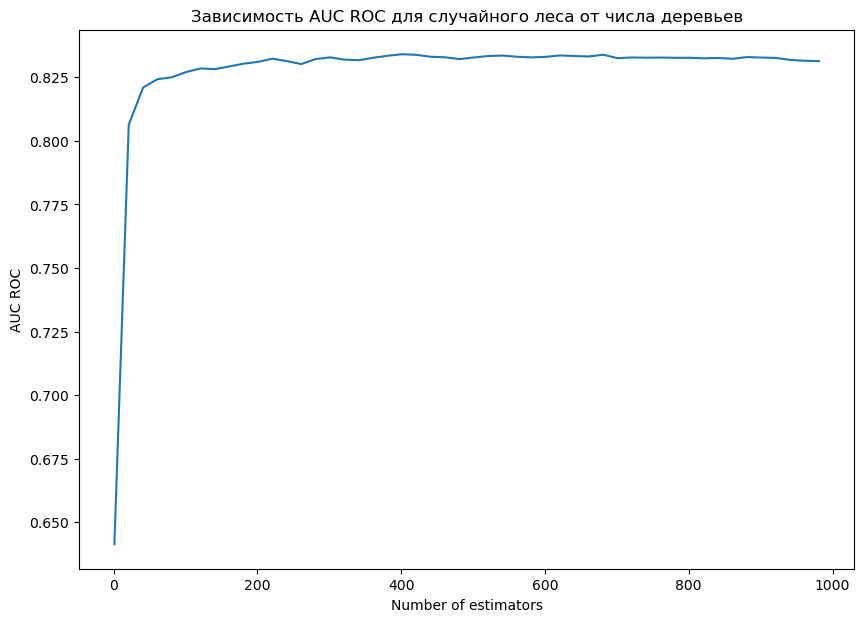

In [33]:
n_estimators_list = np.arange(1, 1000, 20)
auc_arr = []
for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators, random_state = 13)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_test)
    auc_arr.append(roc_auc_score(y_test, y_pred[:,1]))

plt.figure(figsize=(10, 7))
plt.title("Зависимость AUC ROC для случайного леса от числа деревьев")
plt.plot(n_estimators_list, auc_arr)
plt.xlabel("Number of estimators")
plt.ylabel("AUC ROC")

Как можно видеть из графика ROC AUC для случайного леса с какого-то момента достигает определенного значения, после чего колеблется возле него. Это иллюстрирует то, что случайный лес не переобучается.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

                      Names  Feature importances
0               Pregnancies             0.089545
1                   Glucose             0.316298
2             BloodPressure             0.062709
3             SkinThickness             0.062726
4                   Insulin             0.054557
5                       BMI             0.171925
6  DiabetesPedigreeFunction             0.095454
7                       Age             0.146785


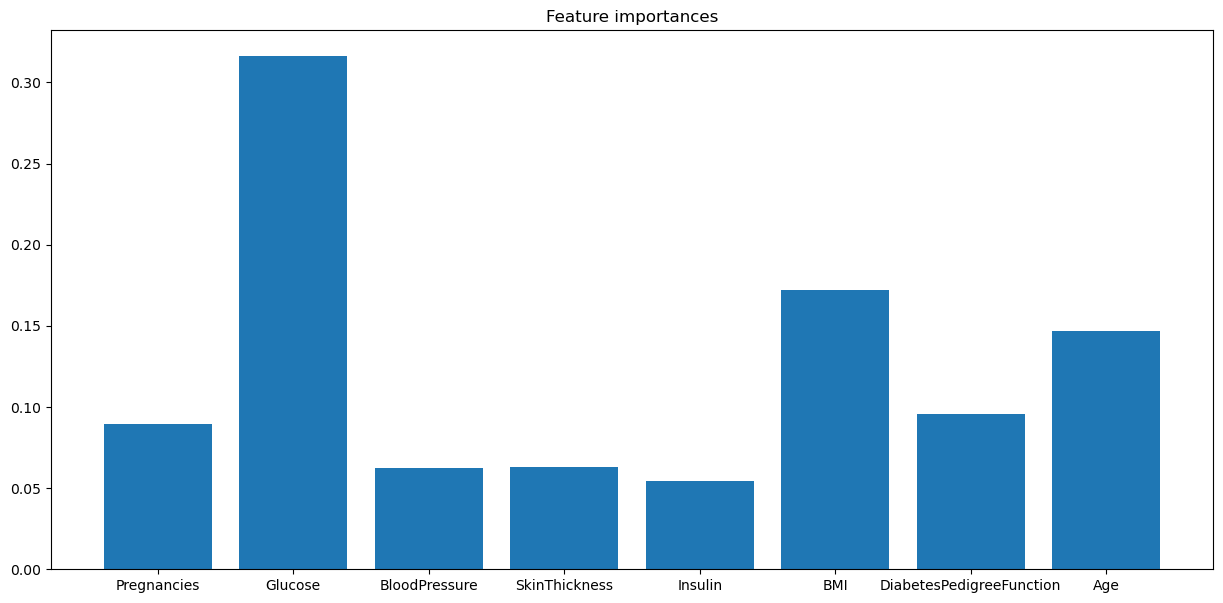

In [34]:
print(pd.DataFrame({'Names': X.columns, 'Feature importances': rf_best.feature_importances_}))

plt.figure(figsize=(15, 7))
plt.title("Feature importances")
plt.bar(X.columns, rf_best.feature_importances_);

Судя по диаграмме, наиболее информативным оказался уровень глюкозы.